# Results
All graphs and results. For discussion please read associated paper.

In [41]:
# Imports for the rest of the notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from discrete_skip_gram.util import stats_string
from tabulate import tabulate
def load_output(path):
    return np.load('../experiments/output/{}'.format(path))
def table(t, **kwargs):
    return HTML(tabulate(t, tablefmt='html', **kwargs))
def bar(x, data, label, axis=1):
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)
    plt.errorbar(x, mean, yerr=std,
                 markersize=3, fmt='-o', label=label)
def data_shapes(x):
    return {k:v.shape for k,v in x.iteritems()}
eps = 1e-9

## Cooccurrence matrix

Import precalculated cooccurrence matrix generated from Brown corpus.

Calculate marginal and conditional entropy.

In [2]:
# Load and normalize cooccurrence matrix
coo = load_output('cooccurrence.npy').astype(np.float32)
p = coo / np.sum(coo, axis=None)
print('Shape of cooccurrence matrix is {}'.format(p.shape))

Shape of cooccurrence matrix is (4946L, 4946L)


In [3]:
# Calculate marginal entropy (unigram)
marginal = np.sum(p, axis=1, keepdims=True)
marginal_nll = np.sum(marginal * -np.log(marginal+eps), axis=None) # E(x) = p(x)*log(p(x))
print('Marginal entropy is {}'.format(marginal_nll))

Marginal entropy is 5.91309642792


In [4]:
# Calculate conditional entropy (skipgram)
conditional = p / marginal
conditional_nll = np.sum(p * -np.log(conditional+eps), axis=None) # H(y|x) = p(x,y)*log(p(y|x))
print('Conditional entropy is {}'.format(conditional_nll))

Conditional entropy is 5.32560062408


## Random Baseline
Randomly cluster the vocabulary and calculate the conditional entropy of the clusters. Conditional entropy decreases as the number of clusters increases.

Cluster the vocabulary into a random binary tree and calculate the conditional entropy of each level of the tree. Conditional entropy decreases as the depth of the tree increases.

Iterations: 100


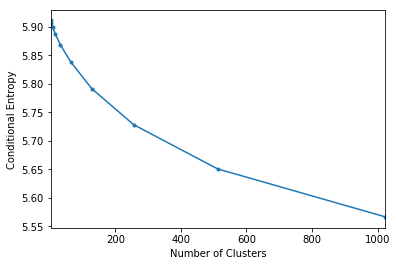

Number of Clusters,Mean Conditional Entropy,Std
2,5.91089,0.000353488
4,5.90664,0.000643125
8,5.89946,0.000901418
16,5.88777,0.00140333
32,5.86821,0.00143286
64,5.83775,0.00177347
128,5.79114,0.00181084
256,5.72796,0.00172552
512,5.65055,0.00197066
1024,5.56641,0.00180625


In [5]:
# Random flat encodings with different numbers of clusters
random = load_output('skipgram_flat_random.npz')
print('Iterations: {}'.format(random['nlls'].shape[1]))
# Plot entropy by number of clusters
mean = np.mean(random['nlls'], axis=1)
std = np.std(random['nlls'], axis=1)
plt.errorbar(random['z_ks'], mean, yerr=std, markersize=3, fmt='-o')
plt.ylabel('Conditional Entropy')
plt.xlabel('Number of Clusters')
plt.xlim(2, 1024)
plt.show()
# Tabulate entropy by number of clusters
t = np.stack([random['z_ks'], mean, std], axis=1)
table(t, headers=['Number of Clusters', 'Mean Conditional Entropy', 'Std'])

Iterations: 50


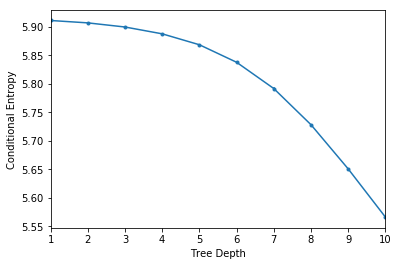

Tree Depth,Mean Conditional Entropy,Std
1,5.91088,0.000436061
2,5.90671,0.000568841
3,5.89945,0.000856081
4,5.8875,0.00120805
5,5.86835,0.00146809
6,5.83765,0.00168684
7,5.7916,0.00197922
8,5.72817,0.00191247
9,5.65073,0.00187701
10,5.56624,0.00149767


In [6]:
# Random tree encoding
tree_random = load_output('skipgram_tree_random.npz')
print('Iterations: {}'.format(tree_random['nlls'].shape[0]))
# Plot entropy by depth
mean = np.mean(tree_random['nlls'], axis=0)
std = np.std(tree_random['nlls'], axis=0)
plt.errorbar(np.arange(1,11), mean, yerr=std, markersize=3, fmt='-o')
plt.ylabel('Conditional Entropy')
plt.xlabel('Tree Depth')
plt.xlim(1,10)
plt.show()
# Tabulate entropy by depth
t = np.stack([np.arange(1,11), mean, std], axis=1)
table(t, headers=['Tree Depth','Mean Conditional Entropy', 'Std'])

## Baseline Skipgram Models

Train baseline skipgram models with different numbers of hidden units (`p=softmax(xW+b)`, `loss=expected(-log(p))`).

Performance with few units approaches the analytically calculated marginal entropy.

Performance with many units approaches the calculated conditional entropy.

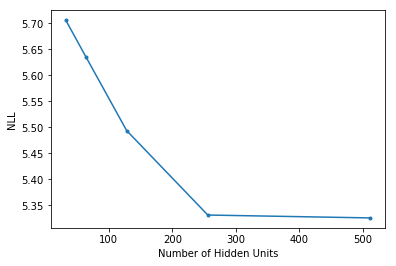

Number of Hidden Units,Mean NLL,Std
512,5.3256,3.69356e-07
256,5.33114,4.66935e-05
128,5.49359,9.51371e-05
64,5.63483,2.18327e-05
32,5.70584,2.80484e-06


In [7]:
# Vanialla baseline model
baseline = load_output('skipgram_baseline.npz')
# Plot NLL by number of hidden units
zks = baseline['z_ks']
mean = np.mean(baseline['nlls'], axis=1)
std = np.std(baseline['nlls'], axis=1)
plt.errorbar(zks, mean, yerr=std, markersize=3, fmt='-o')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.show()
# Tabulate NLL by number of hidden units
t = np.stack([zks, mean, std], axis=1)
table(t, headers=['Number of Hidden Units', 'Mean NLL', 'Std'])

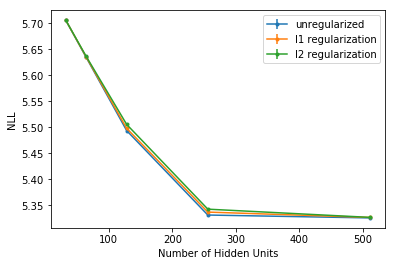

In [14]:
# Vanialla baseline model and regularization
baseline = load_output('skipgram_baseline.npz')
baselinel1 = load_output('skipgram_baseline-l1.npz')
baselinel2 = load_output('skipgram_baseline-l2.npz')
# Plot NLL by number of hidden units
zks = baseline['z_ks']
b = baseline['nlls']
def bar(zks, data, label):
    mean = np.mean(data, axis=1)
    std = np.mean(data, axis=1)
    plt.errorbar(zks, mean, yerr=std,
                 markersize=3, fmt='-o', label=label)
bar(baseline['nlls'], 'unregularized')
bar(baseline['l1'], 'l1 regularization')
bar(baseline['l2'], 'l2 regularization')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

## Binary Models

Experiments with models that cluster the vocabulary into two groups and attempt to minimize the conditional entropy of those clusters.

Proposed binary model outperformed all random and post-hoc clustering.

In [47]:
# Proposed binary model
binary = load_output('skipgram_binary.npz')
print('NLL: {}'.format(stats_string(binary['nlls'])))
print('Utilization: {}'.format(stats_string(binary['utilizations'])))


NLL: Mean 5.88556807427, Std 4.44760411065e-08, Min 5.88556799038, Max 5.88556810479, N 5
Utilization: Mean 2.0, Std 0.0, Min 2, Max 2, N 5


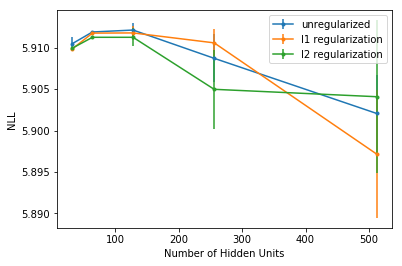

In [43]:
# GMM binary clustering
binary_gmm = load_output('skipgram_baseline_binary_gmm.npz')
# Plot NLL by baseline hidden units
bzks = binary_gmm['bzks']
bar(bzks, binary_gmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_gmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_gmm['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

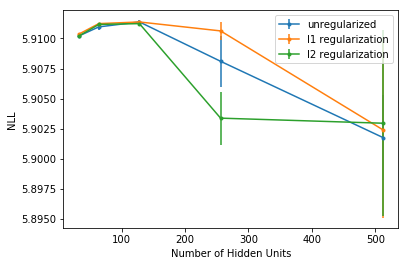

In [44]:
# GMM balanced binary clustering
binary_gmm = load_output('skipgram_baseline_binary_bgmm.npz')
# Plot NLL by baseline hidden units
bzks = binary_gmm['bzks']
bar(bzks, binary_gmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_gmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_gmm['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

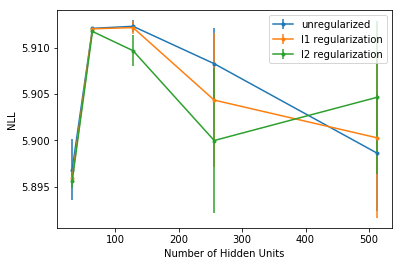

In [45]:
# Kmeans binary clustering
binary_gmm = load_output('skipgram_baseline_binary_kmeans.npz')
# Plot NLL by baseline hidden units
bzks = binary_gmm['bzks']
bar(bzks, binary_gmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_gmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_gmm['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

## Flat Models (k=1024)
Experiments with models that cluster the vocabulary into 1024 groups (`2**10`) and attempt to minimize the conditional entropy of the clusters.

Skipgram model

Random assignment

## Flat models

In [7]:
flat = load_output('skipgram_flat.npz')
print("Flat NLL: {}".format(stats_string(flat['nlls'])))
print("Flat Utilization: {}".format(stats_string(flat['utilizations'])))

Flat NLL: Mean 5.5480435445, Std 0.000778813805342, Min 5.54713744241, Max 5.54945816655, N 5
Flat Utilization: Mean 809.4, Std 4.8, Min 804, Max 816, N 5


Flat model with regularization

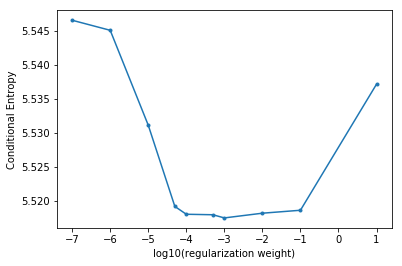

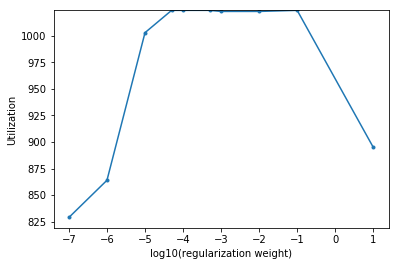

In [13]:
# Flat model with balance regularizer
flat_b = load_output('skipgram_flat-b.npz')
# plot NLL by regularization weight
x = np.log10(flat_b['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_b['nlls'], axis=1)
plt.plot(x, mean, markersize=3, marker='o')
plt.ylabel('Conditional Entropy')
plt.xlabel(xlabel)
plt.show()
meanu = np.mean(flat_b['utilizations'], axis=1)
plt.plot(x, meanu, markersize=3, marker='o')
plt.ylabel('Utilization')
plt.xlabel(xlabel)
plt.ylim(None, 1024)
plt.show()

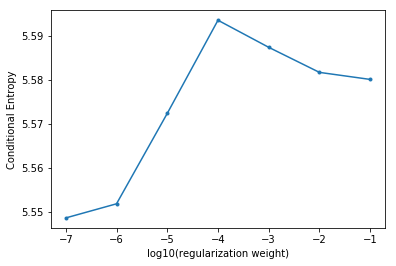

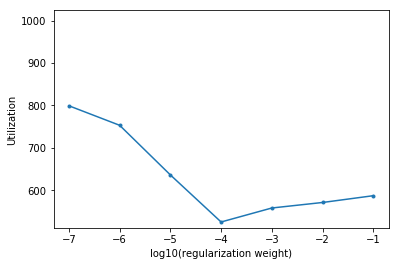

In [14]:
# Flat model with balance we regularizer
flat_bw = load_output('skipgram_flat-bw.npz')
# plot NLL by regularization weight
x = np.log10(flat_bw['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_bw['nlls'], axis=1)
plt.plot(x, mean, markersize=3, marker='o')
plt.ylabel('Conditional Entropy')
plt.xlabel(xlabel)
plt.show()
meanu = np.mean(flat_bw['utilizations'], axis=1)
plt.plot(x, meanu, markersize=3, marker='o')
plt.ylabel('Utilization')
plt.xlabel(xlabel)
plt.ylim(None, 1024)
plt.show()